In [2]:
# !pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=9b46ca1aaf1fb624aa4d4e33c82a3320115d5a0d86395e1c0c27917b4ee8a06b
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [3]:
# !pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=31972432e9ca349549400e52a0b16db87d6de518f1a4d95576e5b25a0467be7f
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [4]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.1 MB/s eta 0:00:00


In [1]:
# !pip install demoji

     ---------------------------------------- 42.9/42.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# %pip install flair

In [1]:
# General purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import re, string
import emoji, demoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from langdetect import detect
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Transformers & Tensorflow
from transformers import BertTokenizerFast
from transformers import TFBertModel
import tensorflow as tf

# FLAIR
from flair.models import TextClassifier
from flair.data import Sentence

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set seed for reproducibility
seed = 42

In [2]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [2]:
train = pd.read_csv('data/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('data/Corona_NLP_test.csv', encoding='latin1')

In [4]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [2]:
# Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() # remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) # remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) # remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) # remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) # remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

## Tweets Cleaning

In [5]:
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]

In [7]:
texts_new = []
for t in train.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [8]:
texts_new_test = []
for t in test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [9]:
train["cleaned_text"] = texts_new
test["cleaned_text"] = texts_new_test

In [10]:
text_len = []
for text in train.cleaned_text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
    
train['text_len'] = text_len

In [11]:
text_len_test = []
for text in test.cleaned_text:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)
    
test['text_len'] = text_len_test

In [12]:
# Some texts are 0 in length and it is safer to extract those of >= 5 words

train = train[train['text_len'] > 4]
test = test[test['text_len'] > 4]

In [13]:
# Detect languages for train set

languages = []
for text in train.cleaned_text:
    lang = detect(text)
    # print(lang)
    languages.append(lang)
    
train['text_lang'] = languages

In [14]:
# Detect languages for test set

languages = []
for text in test.cleaned_text:
    lang = detect(text)
    # print(lang)
    languages.append(lang)
    
test['text_lang'] = languages

In [15]:
# Filter only those in English

train = train[train['text_lang'] == "en"]
test = test[test['text_lang'] == "en"]

## Sentiment column

In [16]:
# Create 3 classes: Negative (0), Neutral (1), Positive (2)

train['Sentiment'] = train['Sentiment'].map({'Extremely Negative':0, 'Negative':0, 'Neutral':1, 'Positive':2, 'Extremely Positive':2})
test['Sentiment'] = test['Sentiment'].map({'Extremely Negative':0, 'Negative':0, 'Neutral':1, 'Positive':2, 'Extremely Positive':2})

<ipython-input-16-e12453a13595>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sentiment'] = train['Sentiment'].map({'Extremely Negative':0, 'Negative':0, 'Neutral':1, 'Positive':2, 'Extremely Positive':2})
<ipython-input-16-e12453a13595>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sentiment'] = test['Sentiment'].map({'Extremely Negative':0, 'Negative':0, 'Neutral':1, 'Positive':2, 'Extremely Positive':2})


In [17]:
# Imbalanced classes present

train['Sentiment'].value_counts()

2    17953
0    15319
1     7451
Name: Sentiment, dtype: int64

In [18]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train['cleaned_text']).reshape(-1, 1), np.array(train['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['cleaned_text', 'Sentiment']);

In [19]:
# Balance restored

train_os['Sentiment'].value_counts()

2    17953
0    17953
1    17953
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [20]:
X = train_os['cleaned_text'].values
y = train_os['Sentiment'].values

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [22]:
X_test = test['cleaned_text'].values
y_test = test['Sentiment'].values

In [23]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [24]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [25]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48473
VALIDATION DATA: 5386
TESTING DATA: 3781


## BERT

In [3]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [4]:
MAX_LEN=128

def tokenize(data, max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [28]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [29]:
def create_model(bert_model, max_len=MAX_LEN):
    
    # params
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model.bert([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [30]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [31]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [33]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=5, batch_size=32)

Epoch 1/5
1515/1515 [==============================] - 1270s 838ms/step - loss: 0.4053 - categorical_accuracy: 0.8543 - val_loss: 0.3066 - val_categorical_accuracy: 0.8968
Epoch 2/5
1515/1515 [==============================] - 1266s 836ms/step - loss: 0.2536 - categorical_accuracy: 0.9121 - val_loss: 0.2425 - val_categorical_accuracy: 0.9176
Epoch 3/5
1515/1515 [==============================] - 1230s 812ms/step - loss: 0.1683 - categorical_accuracy: 0.9423 - val_loss: 0.2299 - val_categorical_accuracy: 0.9233
Epoch 4/5
1515/1515 [==============================] - 1265s 835ms/step - loss: 0.1121 - categorical_accuracy: 0.9636 - val_loss: 0.2330 - val_categorical_accuracy: 0.9255
Epoch 5/5
1515/1515 [==============================] - 1266s 835ms/step - loss: 0.0743 - categorical_accuracy: 0.9766 - val_loss: 0.2436 - val_categorical_accuracy: 0.9346


In [34]:
result_bert = model.predict([test_input_ids, test_attention_masks])

119/119 [==============================] - 37s 278ms/step


In [35]:
y_pred_bert = np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

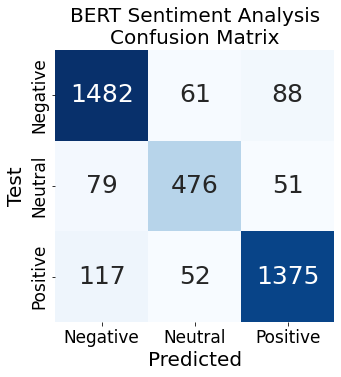

In [36]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1), 'BERT Sentiment Analysis\nConfusion Matrix')

In [37]:
print('\tClassification Report for BERT:\n\n', classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.88      0.91      0.90      1631
     Neutral       0.81      0.79      0.80       606
    Positive       0.91      0.89      0.90      1544

   micro avg       0.88      0.88      0.88      3781
   macro avg       0.87      0.86      0.86      3781
weighted avg       0.88      0.88      0.88      3781
 samples avg       0.88      0.88      0.88      3781



In [38]:
# Save model

model.save("<insert path to save model files>")

In [5]:
# load model

model = tf.keras.models.load_model("<insert path to model files>")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [2]:
# Test one data point

text = "For those who aren't struggling, please consider donating to a food bank or a nonprofit. The demand for these services will increase as COVID-19 impacts jobs, and people's way of life."

In [6]:
processed = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(text)))))
processed_input_ids, processed_attention_masks = tokenize(processed, MAX_LEN)
result = model.predict([processed_input_ids, processed_attention_masks])
result[0]

6/6 [==============================] - 23s 3s/step


array([0.07788973, 0.77101076, 0.15109949], dtype=float32)

In [7]:
def determine_sentiment(index):
    if index == 0:
        return "Negative"
    elif index == 1:
        return "Neutral"
    else:
        return "Positive"

In [8]:
print(determine_sentiment(np.argmax(result[0])))

Neutral


## FLAIR

In [3]:
sia = TextClassifier.load('en-sentiment')

def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "Positive"
    elif "NEGATIVE" in str(score):
        return "Negative"
    else:
        return "Neutral"

print(flair_prediction(text))

Positive


## Time Series Analysis

In [3]:
train_copy = train.copy()
train_copy = train_copy[["TweetAt", "OriginalTweet"]]
train_copy['TweetAt'] = pd.to_datetime(train_copy['TweetAt'], infer_datetime_format=True)
train_copy.set_index("TweetAt", inplace = True)
train_copy.head()

,OriginalTweet
TweetAt,
2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
2020-03-16,advice Talk to your neighbours family to excha...
2020-03-16,Coronavirus Australia: Woolworths to give elde...
2020-03-16,My food stock is not the only one which is emp...
2020-03-16,"Me, ready to go at supermarket during the #COV..."


In [4]:
sentiment_scores = train_copy['OriginalTweet'].apply(sid.polarity_scores)
sentiment_scores

TweetAt
2020-03-16    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2020-03-16    {'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...
2020-03-16    {'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...
2020-03-16    {'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...
2020-03-16    {'neg': 0.079, 'neu': 0.713, 'pos': 0.208, 'co...
                                    ...                        
2020-04-14    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2020-04-14    {'neg': 0.206, 'neu': 0.794, 'pos': 0.0, 'comp...
2020-04-14    {'neg': 0.072, 'neu': 0.77, 'pos': 0.158, 'com...
2020-04-14    {'neg': 0.139, 'neu': 0.717, 'pos': 0.143, 'co...
2020-04-14    {'neg': 0.117, 'neu': 0.807, 'pos': 0.077, 'co...
Name: OriginalTweet, Length: 41157, dtype: object

In [5]:
sentiments = sentiment_scores.apply(lambda x: x["compound"])
sentiments.to_frame()

,OriginalTweet
TweetAt,
2020-03-16,0.0000
2020-03-16,0.2500
2020-03-16,0.4588
2020-03-16,0.8731
2020-03-16,0.7161
...,...
2020-04-14,0.0000
2020-04-14,-0.6369
2020-04-14,0.4184


In [6]:
senti_average = sentiments.groupby(sentiments.index).mean()
senti_average

TweetAt
2020-03-16    0.009877
2020-03-17   -0.014178
2020-03-18    0.004248
2020-03-19    0.004255
2020-03-20   -0.020395
2020-03-21    0.019048
2020-03-22    0.056135
2020-03-23    0.061454
2020-03-24    0.020057
2020-03-25    0.081939
2020-03-26    0.059690
2020-03-27   -0.016346
2020-03-28    0.376904
2020-03-29    0.153330
2020-03-30   -0.044315
2020-03-31    0.034875
2020-04-01   -0.001207
2020-04-02    0.030081
2020-04-03    0.025278
2020-04-04    0.049100
2020-04-05    0.083671
2020-04-06    0.039006
2020-04-07    0.049902
2020-04-08    0.084118
2020-04-09    0.096789
2020-04-10    0.085971
2020-04-11    0.086544
2020-04-12    0.044867
2020-04-13    0.058335
2020-04-14    0.023554
Name: OriginalTweet, dtype: float64

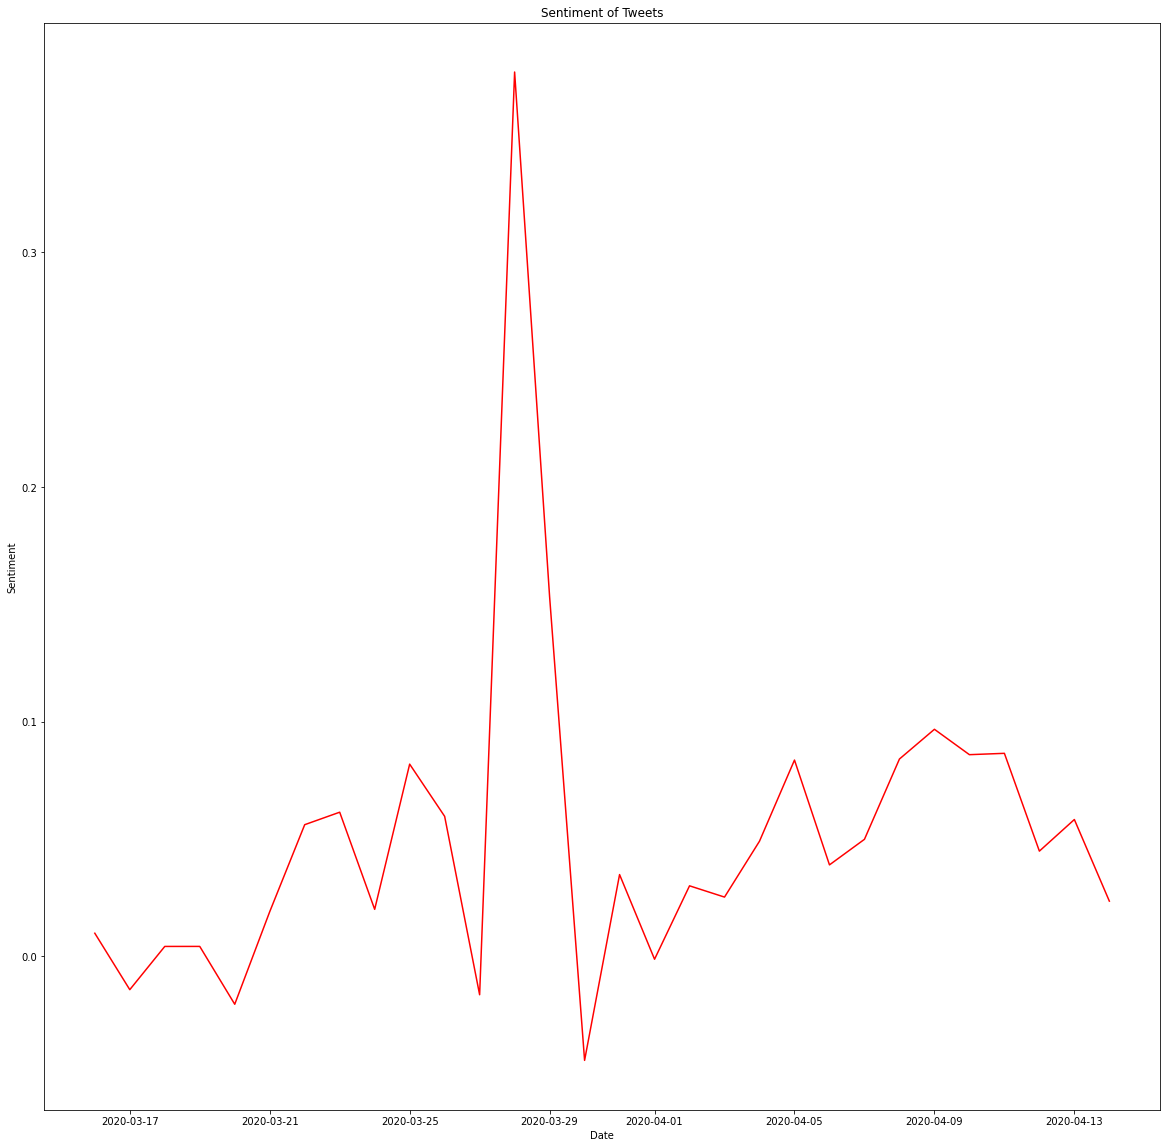

In [7]:
# Plot sentiment over time

fig = plt.figure(figsize=(20, 20))
plt.plot(senti_average.index, senti_average, color = 'red')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment of Tweets')
# plt.legend(('', ''))
plt.show()